Refrences:
1. https://www.kaggle.com/code/joydeb28/text-classification-with-bert-pytorch
2. https://medium.com/@raoashish10/fine-tuning-a-pre-trained-bert-model-for-classification-using-native-pytorch-c5f33e87616e

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW  # Corrected import
from tqdm import tqdm
import torch
import torch.nn as nn
from transformers import AutoModel
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TTS/combined_emotion.csv')
df.columns = ['text', 'emotion']

,text,emotion
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sad
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sad
4,i am a kindergarten teacher and i am thoroughl...,fear
...,...,...
422741,i begun to feel distressed for you,fear
422742,i left feeling annoyed and angry thinking that...,anger
422743,i were to ever get married i d have everything...,joy
422744,i feel reluctant in applying there because i w...,fear


In [ ]:
df.head()

,text,emotion
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sad
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sad
4,i am a kindergarten teacher and i am thoroughl...,fear


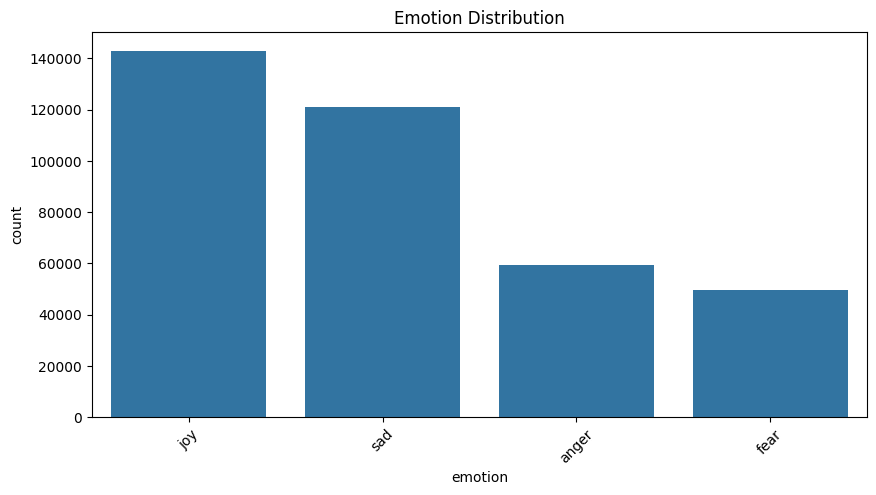

In [ ]:
valid_emotions = ['joy', 'sad', 'anger', 'fear']
df = df[df['emotion'].isin(valid_emotions)]

plt.figure(figsize=(10,5))
sns.countplot(data=df, x='emotion', order=df['emotion'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Emotion Distribution")
plt.show()

In [ ]:
label_mapping = {label: idx for idx, label in enumerate(df['emotion'].unique())}
df['emotion'] = df['emotion'].map(label_mapping)
print("Label Mapping (Emotion):", label_mapping)

Label Mapping (Emotion): {'fear': 0, 'sad': 1, 'joy': 2, 'anger': 3}


In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(), df['emotion'].tolist(), test_size=0.2, random_state=42, stratify=df['emotion']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    test_texts, test_labels, test_size=0.1, random_state=42, stratify=test_labels
)

In [ ]:
print(f"Training size: {len(train_texts)}, Validation size: {len(val_texts)}, Test size: {len(test_texts)}")

Training size: 298576, Validation size: 67179, Test size: 7465


In [ ]:


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


def encode_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
        add_special_tokens=True
    )


train_encodings = encode_texts(train_texts, tokenizer)
val_encodings = encode_texts(val_texts, tokenizer)
test_encodings = encode_texts(test_texts, tokenizer)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Train encoding keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Train sample input_ids: tensor([  101,  1045,  2359,  2000,  2224,  4138, 12760,  1998,  2601, 13207,
         2015,  2000,  2674,  1996,  2514,  1997,  1996,  4825, 11552,  1998,
        27471,  2012,  2320,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0, 

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel
from transformers import AutoModelForSequenceClassification, AutoConfig,AutoModel


class BertClassifier(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", num_labels=4, dropout_prob=0.3, num_dropouts=3):
        super(BertClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.num_dropouts = num_dropouts
        self.dropouts = nn.ModuleList([nn.Dropout(dropout_prob) for _ in range(num_dropouts)])
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        out_1 = outputs.last_hidden_state[:, 0]

        drop_list_out = [self.classifier(dropout(out_1)) for dropout in self.dropouts]
        logits = torch.stack(drop_list_out, dim=0).mean(dim=0)

        return logits




In [ ]:
train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [ ]:
model = model = BertClassifier(num_labels=4, dropout_prob=0.3, num_dropouts=5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")  # Use CPU for debugging
# model.to(device)
print(device)
model.to(device)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

cuda


BertClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = CrossEntropyLoss()

In [ ]:
print(set(test_labels))

{0, 1, 2, 3}


In [ ]:
# Fixing Training Loop and Model Handling
def train_model(model, train_loader, val_loader, epochs=5):
    model.train()
    train_losses, train_accuracies = [], []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}")
        total_loss = 0
        correct = 0
        total = 0

        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()


            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        accuracy = correct / total
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(accuracy)
        print(f"Training Loss: {train_losses[-1]:.4f} | Training Accuracy: {accuracy:.4f}")


        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total
        print(f"Validation Loss: {val_loss / len(val_loader):.4f} | Validation Accuracy: {val_accuracy:.4f}")
        model.train()

    return train_losses, train_accuracies


train_losses, train_accuracies = train_model(model, train_loader, val_loader)



Epoch 1


  0%|          | 0/2333 [00:00<?, ?it/s]<ipython-input-12-8f0623f5f1f2>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 2333/2333 [10:37<00:00,  3.66it/s]


Training Loss: 0.1130 | Training Accuracy: 0.9528
Validation Loss: 0.0458 | Validation Accuracy: 0.9746
Epoch 2


100%|██████████| 2333/2333 [10:36<00:00,  3.67it/s]


Training Loss: 0.0432 | Training Accuracy: 0.9758
Validation Loss: 0.0400 | Validation Accuracy: 0.9761
Epoch 3


100%|██████████| 2333/2333 [10:36<00:00,  3.66it/s]


Training Loss: 0.0380 | Training Accuracy: 0.9771
Validation Loss: 0.0395 | Validation Accuracy: 0.9765
Epoch 4


100%|██████████| 2333/2333 [10:36<00:00,  3.66it/s]


Training Loss: 0.0349 | Training Accuracy: 0.9783
Validation Loss: 0.0411 | Validation Accuracy: 0.9762
Epoch 5


100%|██████████| 2333/2333 [10:36<00:00,  3.66it/s]


Training Loss: 0.0327 | Training Accuracy: 0.9790
Validation Loss: 0.0419 | Validation Accuracy: 0.9762


In [ ]:
save_path = "/content/drive/MyDrive/TTS/bert_classifier_3.pt"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Model saved to /content/drive/MyDrive/TTS/bert_classifier_3.pt


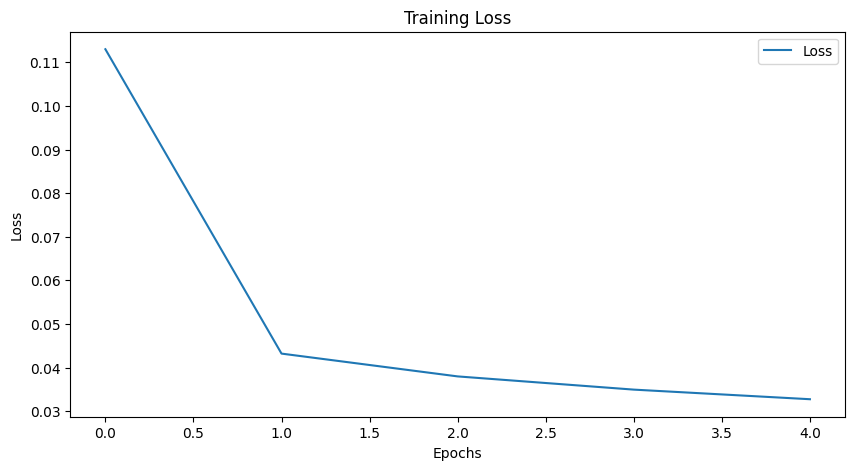

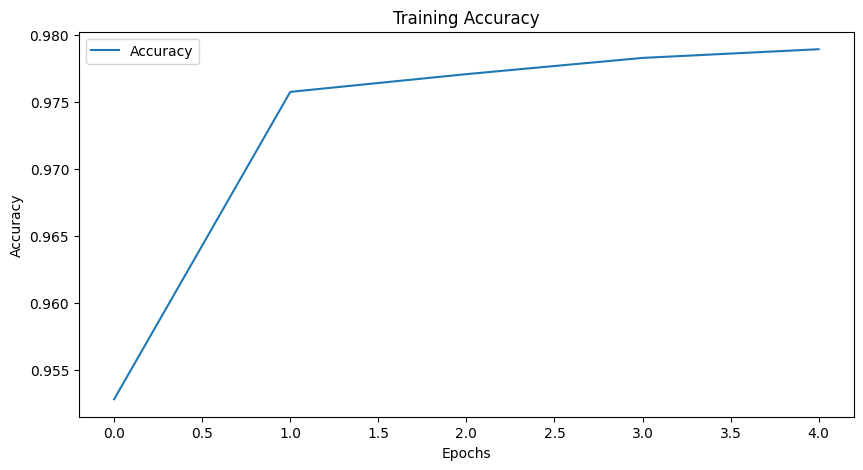

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label='Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = BertClassifier(model_name="distilbert-base-uncased", num_labels=4).to(device)
model2.load_state_dict(torch.load("/content/drive/MyDrive/TTS/bert_classifier_2.pt", map_location=device))
model2.eval()

<ipython-input-12-8f0623f5f1f2>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


['fear', 'sad', 'joy', 'anger']
Accuracy: 0.9720

Classification Report:
              precision    recall  f1-score   support

        fear       0.92      0.96      0.94       993
         sad       0.98      0.96      0.97      2424
         joy       1.00      1.00      1.00      2862
       anger       0.94      0.95      0.94      1186

    accuracy                           0.97      7465
   macro avg       0.96      0.97      0.96      7465
weighted avg       0.97      0.97      0.97      7465



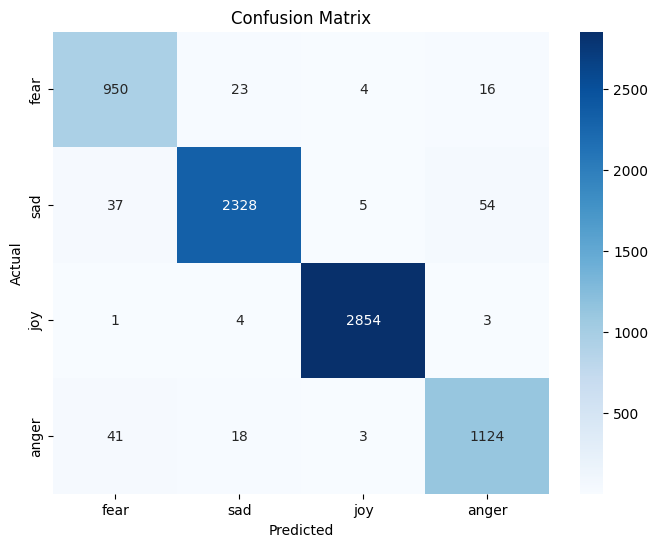

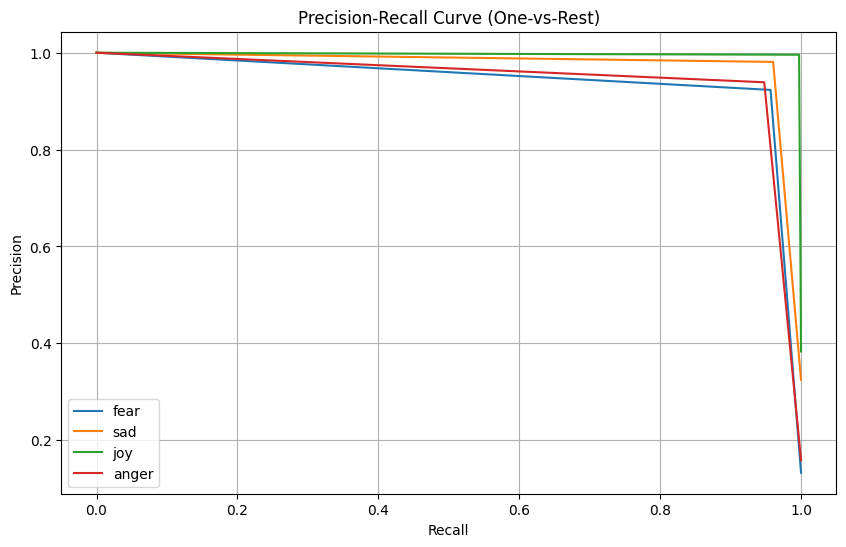

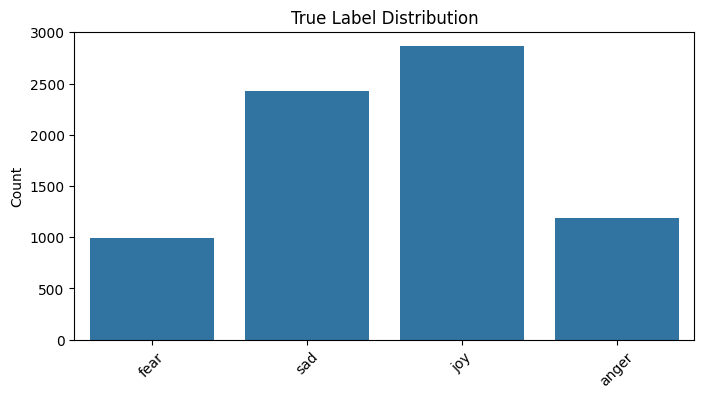

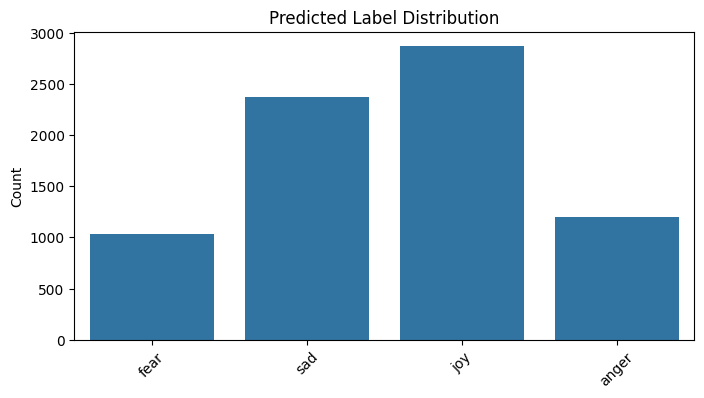

In [ ]:

def evaluate_model(model, test_loader, label_mapping):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    label_names = list(label_mapping.keys())
    print(label_names)
    acc = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    plt.figure(figsize=(10, 6))
    for i in range(len(label_names)):
        y_true = (all_labels == i).astype(int)
        y_scores = (all_preds == i).astype(int)
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        plt.plot(recall, precision, label=f'{label_names[i]}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (One-vs-Rest)')
    plt.legend()
    plt.grid()
    plt.show()

    support_counts = np.bincount(all_labels, minlength=len(label_names))
    plt.figure(figsize=(8, 4))
    sns.barplot(x=label_names, y=support_counts)
    plt.title('True Label Distribution')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

    pred_counts = np.bincount(all_preds, minlength=len(label_names))
    plt.figure(figsize=(8, 4))
    sns.barplot(x=label_names, y=pred_counts)
    plt.title('Predicted Label Distribution')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()


evaluate_model(model2, test_loader, label_mapping)
